In [125]:
import numpy as np
from matplotlib import pyplot as plt
import cvxpy as cp

plt.rcParams.update({'font.size': 14})

Constants

In [126]:
n = 2
m = 6
p = 1
q = 1

Step size $\alpha_k = \dfrac{2}{(k+1)^{0.6}}$

In [127]:
def step(k):
    return 2 / ((k+1)**(0.6))

Communication graph (period = 4)

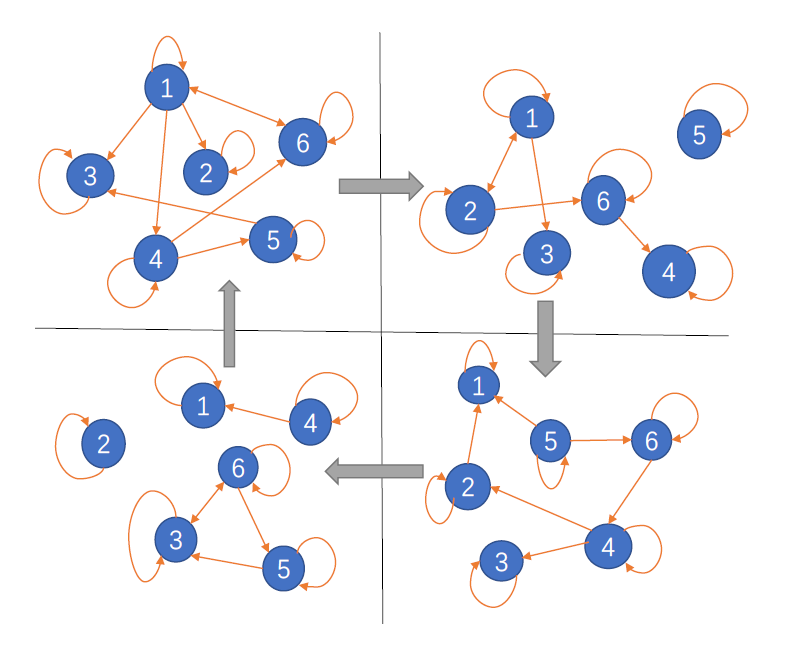

Adjacency matrices

In [128]:
E0 = np.array([[1, 1, 1, 1, 0, 1],
               [0, 1, 0, 0, 0, 0],
               [0, 0, 1, 0, 0, 0],
               [0, 0, 0, 1, 1, 1],
               [0, 0, 1, 0, 1, 0],
               [1, 0, 0, 0, 0, 1]])

In [129]:
E1 = np.array([[1, 1, 1, 0, 0, 0],
               [1, 1, 0, 0, 0, 1],
               [0, 0, 1, 0, 0, 0],
               [0, 0, 0, 1, 0, 0],
               [0, 0, 0, 0, 1, 0],
               [0, 0, 0, 1, 0, 1]])

In [130]:
E2 = np.array([[1, 0, 0, 0, 0, 0],
               [1, 1, 0, 0, 0, 0],
               [0, 0, 1, 0, 0, 0],
               [0, 1, 1, 1, 0, 0],
               [1, 0, 0, 0, 1, 1],
               [0, 0, 0, 1, 0, 1]])

In [131]:
E3 = np.array([[1, 0, 0, 0, 0, 0],
               [0, 1, 0, 0, 0, 0],
               [0, 0, 1, 0, 0, 1],
               [1, 0, 0, 1, 0, 0],
               [0, 0, 1, 0, 1, 0],
               [0, 0, 1, 0, 1, 1]])

In [132]:
def E(k):
    if k % 4 == 0:
        return E0.T
    elif k % 4 == 1:
        return E1.T
    elif k % 4 == 2:
        return E2.T
    elif k % 4 == 3:
        return E3.T

Objective functions and constraints

In [135]:
a = np.array([[0.4, 0.4],
              [0.7, 0.6],
              [0.8, 0.4],
              [0.2, 0.1],
              [0.8, 0.2],
              [0.4, 0.6]])

b = np.array([-5, 3, 0, -7, 6, -8])

c = np.array([0.1, 0.8, 0.3, 0.6, 1, 0.4])

d = np.array([[0.2, 0.3],
              [0.8, 0.5],
              [0.8, 0.4],
              [0.3, 0],
              [0.7, 0.4],
              [0.5, 0.6]])

alpha = np.array([0.1, 0.3, 0.8, 0.7, 0.1, 0.1])

beta = np.array([-0.1, -0.6, -0.1, -0.1, -0.1, -0.1])

gamma = np.array([[0.8, 0.4],
                  [0.1, -0.6],
                  [-0.6, -0.8],
                  [0.8, 0.4],
                  [0.1, -0.4],
                  [-0.7, 0.2]])

delta = np.array([0.5, -0.3, -0.2, -0.1, -0.4, 0.2])

In [134]:
a = np.random.rand(6, 2)

b = np.random.rand(6)

c = np.random.rand(6)

d = np.random.rand(6, 2)

alpha = np.random.rand(6)

beta = - np.random.rand(6)

gamma = np.random.rand(6, 2)

delta = np.random.rand(6)

In [136]:
def f(i, x):
    return a[i] @ x + b[i] + c[i] * np.log(1 + np.exp(d[i] @ x))

def h1(i, x):
    return alpha[i] * np.linalg.norm(x) ** 2 + beta[i]

def h2(i, x):
    return gamma[i] @ x + delta[i]

def h(i, x):
    return np.array([h1(i, x), h2(i, x)])

def F(x):
    return np.sum([f(i, x) for i in range(m)])

In [137]:
def grad_f(i, x):
    return a[i] + c[i] * d[i] * np.exp(d[i] @ x) / (1 + np.exp(d[i] @ x))

def grad_h1(i, x):
    return 2 * alpha[i] * x

def grad_h2(i, x):
    return gamma[i]

def grad_h(i, x):
    return np.vstack((grad_h1(i, x), grad_h2(i, x)))

Gossip matrices

In [138]:
def N_in(k, i):
    return np.sum(E(k)[i])

def N_out(k, j):
    return np.sum(E(k)[:, j])

In [139]:
def A(k):
    A = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            if E(k)[i, j] == 1:
                A[i, j] = 1 / N_in(k, i)
    return A

def B(k):
    B = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            if E(k)[i, j] == 1:
                B[i, j] = 1 / N_out(k, j)
    return B

Projections

In [140]:
def P_cut(a, b, c):
    if c < a:
        return a
    elif a <= c <= b:
        return c
    elif c > b:
        return b

In [141]:
def P_X(x):
    y = np.empty_like(x)
    for i in range(len(x)):
        if x[i] < -3:
            y[i] = -3
        elif -3 <= x[i] <= 3:
            y[i] = x[i]
        elif x[i] > 3:
            y[i] = 3
    return y

In [142]:
def P_Q(lmbd):
    # p1 = lmbd[0] if lmbd[0] >= 0 else 0
    p1 = P_cut(0, 5, lmbd[0])
    p2 = lmbd[1]
    return np.array([p1, p2])

# PushPull

### Solving via CVXPY

In [143]:
x = cp.Variable(2)

f0 = a[0] @ x + b[0] + c[0] * cp.logistic(d[0] @ x)
f1 = a[1] @ x + b[1] + c[1] * cp.logistic(d[1] @ x)
f2 = a[2] @ x + b[2] + c[2] * cp.logistic(d[2] @ x)
f3 = a[3] @ x + b[3] + c[3] * cp.logistic(d[3] @ x)
f4 = a[4] @ x + b[4] + c[4] * cp.logistic(d[4] @ x)
f5 = a[5] @ x + b[5] + c[5] * cp.logistic(d[5] @ x)
func = f0 + f1 + f2 + f3 + f4 + f5

h01 = alpha[0] * cp.norm(x) ** 2 + beta[0]
h02 = gamma[0] @ x + delta[0]

h11 = alpha[1] * cp.norm(x) ** 2 + beta[1]
h12 = gamma[1] @ x + delta[1]

h21 = alpha[2] * cp.norm(x) ** 2 + beta[2]
h22 = gamma[2] @ x + delta[2]

h31 = alpha[3] * cp.norm(x) ** 2 + beta[3]
h32 = gamma[3] @ x + delta[3]

h41 = alpha[4] * cp.norm(x) ** 2 + beta[4]
h42 = gamma[4] @ x + delta[4]

h51 = alpha[5] * cp.norm(x) ** 2 + beta[5]
h52 = gamma[5] @ x + delta[5]

obj = cp.Minimize(func)

constraints = [h01 + h11 + h21 + h31 + h41 + h51 <= 0,
               h02 + h12 + h22 + h32 + h42 + h52 == 0,
               x >= -3,
               x <= 3]

prob = cp.Problem(obj, constraints)

In [144]:
prob.solve()

-12.10401884506871

In [145]:
x_opt = x.value
x_opt

array([-0.38278084, -0.61423803])

In [146]:
lambda_opt = np.array([constraints[0].dual_value, constraints[1].dual_value])
lambda_opt

array([ 1.785632  , -2.34019726])

### Algorithm

In [147]:
def PushPull(n_iter, x0, lambda0):

    y0 = np.zeros((m, 2))
    z0 = np.zeros((m, 2))

    for i in range(m):
        y0[i] = h(i, x0[i])
        z0[i] = grad_f(i, x0[i]) + grad_h(i, x0[i]) @ lambda0[i]

    x_k = np.zeros((n_iter, m, 2))
    lambda_k = np.zeros((n_iter, m, 2))
    y_k = np.zeros((n_iter, m, 2))
    d_k = np.zeros((n_iter, m, 2))
    z_k = np.zeros((n_iter, m, 2))

    x_k[0] = x0
    lambda_k[0] = lambda0
    y_k[0] = y0
    z_k[0] = z0

    k = 0

    while k <= n_iter-2:
        for i in range(m):
            x_k[k+1][i] = P_X(A(k)[i] @ x_k[k] - step(k) * z_k[k][i])
            lambda_k[k+1][i] = P_Q(A(k)[i] @ lambda_k[k] + step(k) * y_k[k][i]) 
            y_k[k+1][i] = B(k)[i] @ y_k[k] + h(i, x_k[k+1][i]) - h(i, x_k[k][i])
            d_k[k][i] = grad_f(i, x_k[k][i]) + grad_h(i, x_k[k][i]) @ lambda_k[k][i]
            d_k[k+1][i] = grad_f(i, x_k[k+1][i]) + grad_h(i, x_k[k+1][i]) @ lambda_k[k+1][i]
            z_k[k+1][i] = B(k)[i] @ z_k[k] + d_k[k+1][i] - d_k[k][i]
        k = k + 1

    return x_k, lambda_k

### Implementation

In [148]:
n_iter = 10000
x0 = np.zeros((6, 2))
lambda0 = np.zeros((6, 2))

x_k, lambda_k = PushPull(n_iter, x0, lambda0)

Last iteration

In [149]:
x_k[-1].mean(axis=0)

array([-3.        ,  2.98408902])

In [150]:
lambda_k[-1].mean(axis=0)

array([5.        , 6.08911146])

Some plots

Text(0, 0.5, '$\\| x_i^k - x^* \\|$')

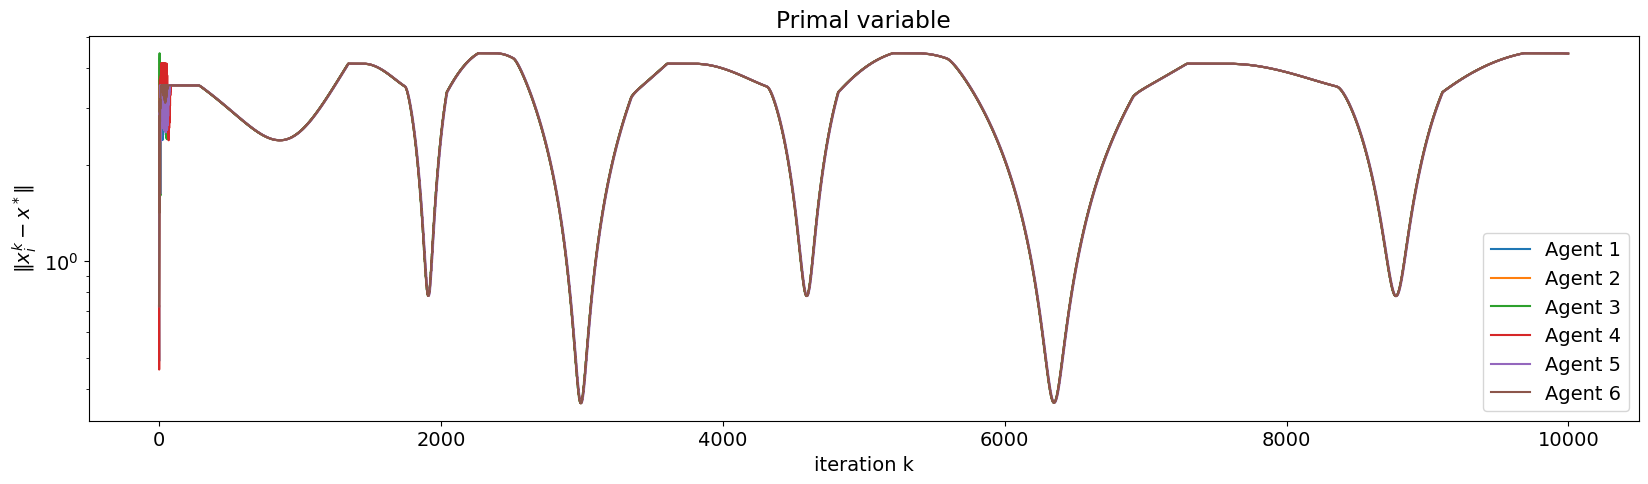

In [151]:
plt.figure(figsize=(20, 5))

for i in range(m):
    plt.plot(range(x_k.shape[0]-1), [np.linalg.norm(x_k[k][i] - x_opt) for k in range(x_k.shape[0]-1)], label=f"Agent {i+1}")

plt.yscale('log')
plt.legend()
plt.title("Primal variable")
plt.xlabel("iteration k")
plt.ylabel("$\| x_i^k - x^* \|$")

Text(0, 0.5, '$\\| \\lambda_i^k - \\lambda^* \\|$')

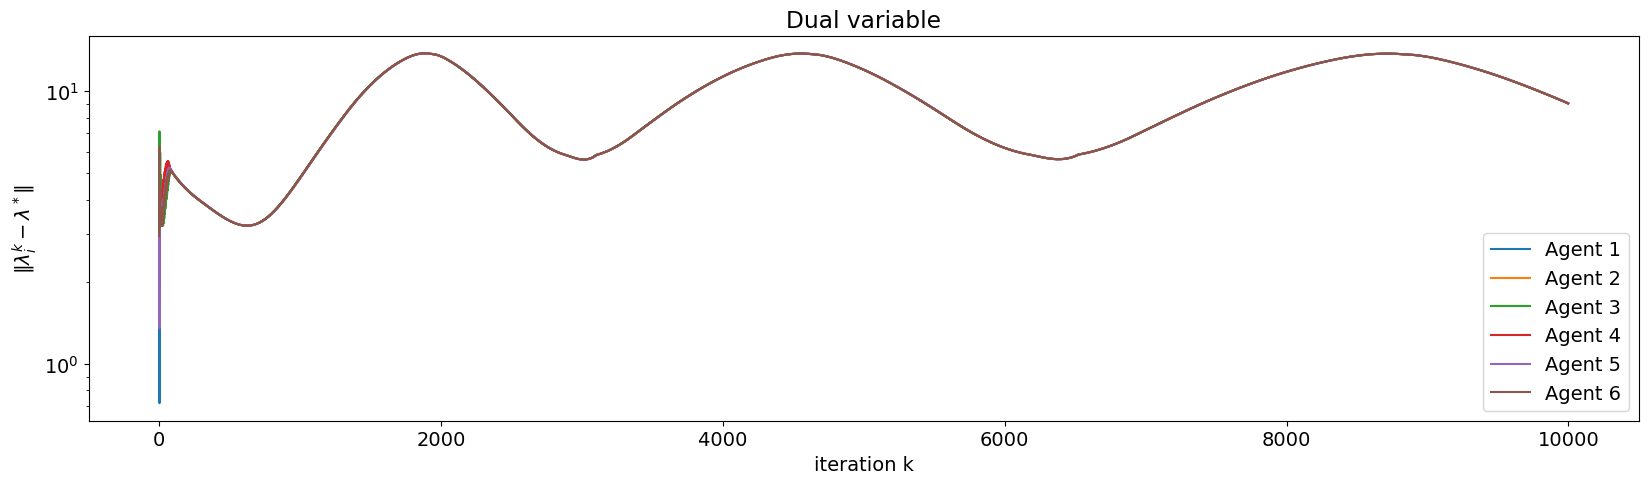

In [152]:
plt.figure(figsize=(20, 5))

for i in range(m):
    plt.plot(range(lambda_k.shape[0]-1), [np.linalg.norm(lambda_k[k][i] - lambda_opt) for k in range(lambda_k.shape[0]-1)], label=f"Agent {i+1}")
    
plt.yscale('log')
plt.legend()
plt.title("Dual variable")
plt.xlabel("iteration k")
plt.ylabel("$\| \lambda_i^k - \lambda^* \|$")

Text(0, 0.5, '$ \\sum_{i=1}^{m} (f_i(x_i^k) - f_i(x^*)) $')

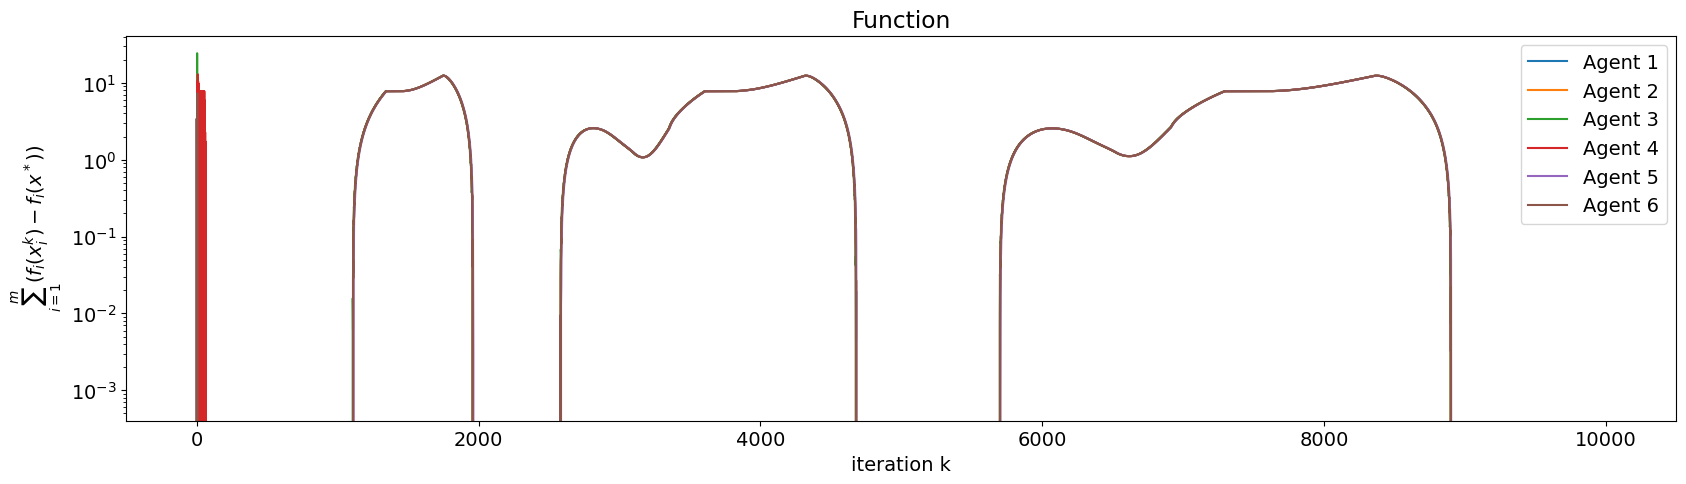

In [153]:
plt.figure(figsize=(20, 5))

for i in range(m):
    plt.plot(range(x_k.shape[0]-1), [F(x_k[k][i]) - F(x_opt) for k in range(x_k.shape[0]-1)], label=f"Agent {i+1}")
    
plt.yscale('log')
plt.legend()
plt.title("Function")
plt.xlabel("iteration k")
plt.ylabel("$ \sum_{i=1}^{m} (f_i(x_i^k) - f_i(x^*)) $")

# PushPull (only equalities)

### Solving via CVXPY

In [94]:
x = cp.Variable(2)

f0 = a[0] @ x + b[0] + c[0] * cp.logistic(d[0] @ x)
f1 = a[1] @ x + b[1] + c[1] * cp.logistic(d[1] @ x)
f2 = a[2] @ x + b[2] + c[2] * cp.logistic(d[2] @ x)
f3 = a[3] @ x + b[3] + c[3] * cp.logistic(d[3] @ x)
f4 = a[4] @ x + b[4] + c[4] * cp.logistic(d[4] @ x)
f5 = a[5] @ x + b[5] + c[5] * cp.logistic(d[5] @ x)
func = f0 + f1 + f2 + f3 + f4 + f5

h02 = gamma[0] @ x + delta[0]

h12 = gamma[1] @ x + delta[1]

h22 = gamma[2] @ x + delta[2]

h32 = gamma[3] @ x + delta[3]

h42 = gamma[4] @ x + delta[4]

h52 = gamma[5] @ x + delta[5]

obj = cp.Minimize(func)

constraints = [h02 + h12 + h22 + h32 + h42 + h52 == 0,
               x >= -3,
               x <= 3]

prob = cp.Problem(obj, constraints)

In [98]:
prob.solve()

-25.74049854290306

In [99]:
x_opt = x.value
x_opt

array([-2.99999999, -2.24999999])

In [100]:
lambda_opt = constraints[0].dual_value
lambda_opt

2.9429477281763434

### Algorithm

In [101]:
def PushPullE(n_iter, x0, lambda0):

    y0 = np.array([h2(i, x0[i]) for i in range(m)])
    z0 = np.array([grad_f(i, x0[i]) + grad_h2(i, x0[i]) * lambda0[i] for i in range(m)])
    
    k = 0

    x_k = np.zeros((n_iter, m, 2))
    lambda_k = np.zeros((n_iter, m))
    y_k = np.zeros((n_iter, m))
    d_k = np.zeros((n_iter, m, 2))
    z_k = np.zeros((n_iter, m, 2))

    x_k[0] = x0
    lambda_k[0] = lambda0
    y_k[0] = y0
    z_k[0] = z0

    while k <= n_iter-2:
        for i in range(m):
            x_k[k+1][i] = P_X(A(k)[i] @ x_k[k] - step(k) * z_k[k][i])
            lambda_k[k+1][i] = A(k)[i] @ lambda_k[k] + step(k) * y_k[k][i]
            y_k[k+1][i] = B(k)[i] @ y_k[k] + h2(i, x_k[k+1][i]) - h2(i, x_k[k][i])
            d_k[k][i] = grad_f(i, x_k[k][i]) + grad_h2(i, x_k[k][i]) * lambda_k[k][i]
            d_k[k+1][i] = grad_f(i, x_k[k+1][i]) + grad_h2(i, x_k[k+1][i]) * lambda_k[k+1][i]
            z_k[k+1][i] = B(k)[i] @ z_k[k] + d_k[k+1][i] - d_k[k][i]
        k = k + 1

    return x_k, lambda_k

### Implementation

In [102]:
n_iter = 10000
x0 = np.zeros((6, 2))
lambda0 = np.zeros(6)

x_k, lambda_k = PushPullE(n_iter, x0, lambda0)

Last iteration

In [103]:
x_k[-1].mean(axis=0)

array([-3.        , -2.73516942])

In [104]:
lambda_k[-1].mean(axis=0)

2.461213191077508

Some plots

Text(0, 0.5, '$\\| x_i^k - x^* \\|$')

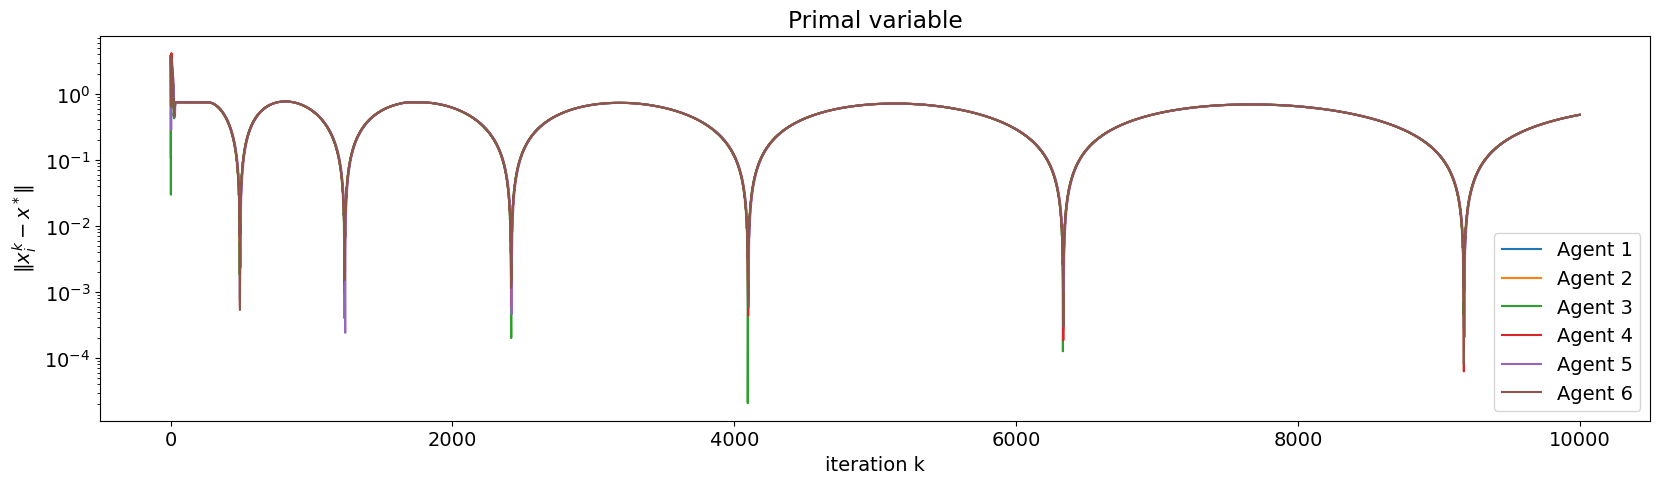

In [105]:
plt.figure(figsize=(20, 5))

for i in range(m):
    plt.plot(range(x_k.shape[0]-1), [np.linalg.norm(x_k[k][i] - x_opt) for k in range(x_k.shape[0]-1)], label=f"Agent {i+1}")

plt.yscale('log')
plt.legend()
plt.title("Primal variable")
plt.xlabel("iteration k")
plt.ylabel("$\| x_i^k - x^* \|$")

Text(0, 0.5, '$\\| \\lambda_i^k - \\lambda^* \\|$')

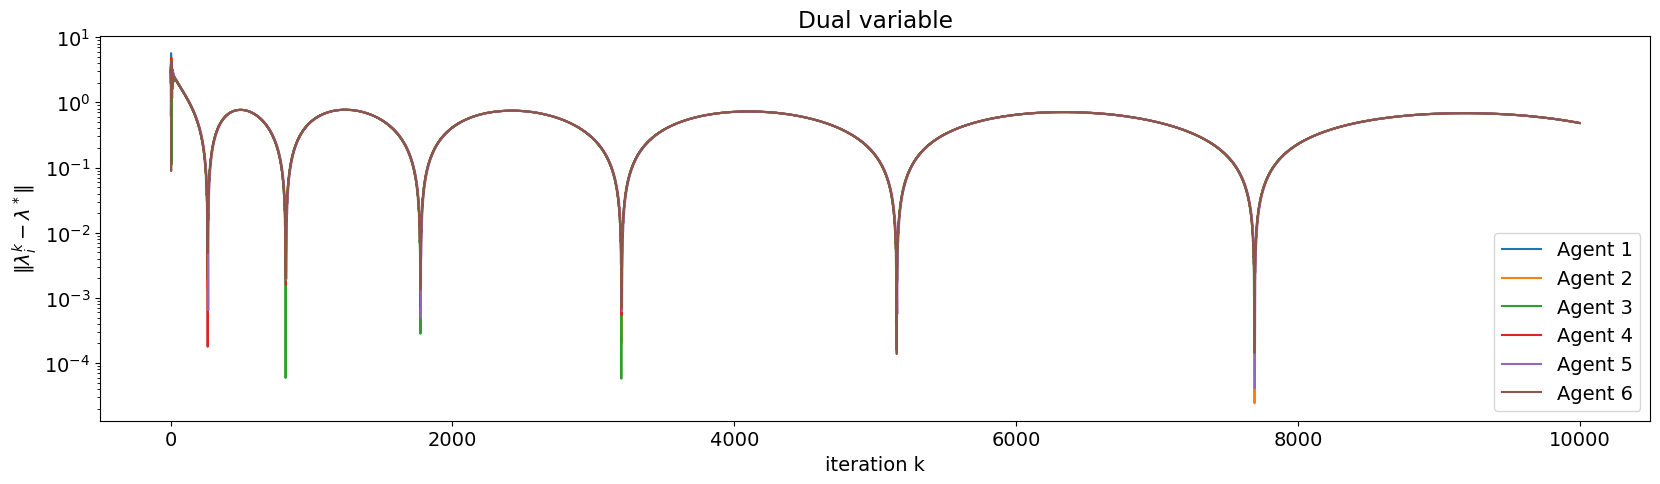

In [106]:
plt.figure(figsize=(20, 5))

for i in range(m):
    plt.plot(range(lambda_k.shape[0]-1), [np.linalg.norm(lambda_k[k][i] - lambda_opt) for k in range(lambda_k.shape[0]-1)], label=f"Agent {i+1}")
    
plt.yscale('log')
plt.legend()
plt.title("Dual variable")
plt.xlabel("iteration k")
plt.ylabel("$\| \lambda_i^k - \lambda^* \|$")

Text(0, 0.5, '$ \\sum_{i=1}^{m} (f_i(x_i^k) - f_i(x^*)) $')

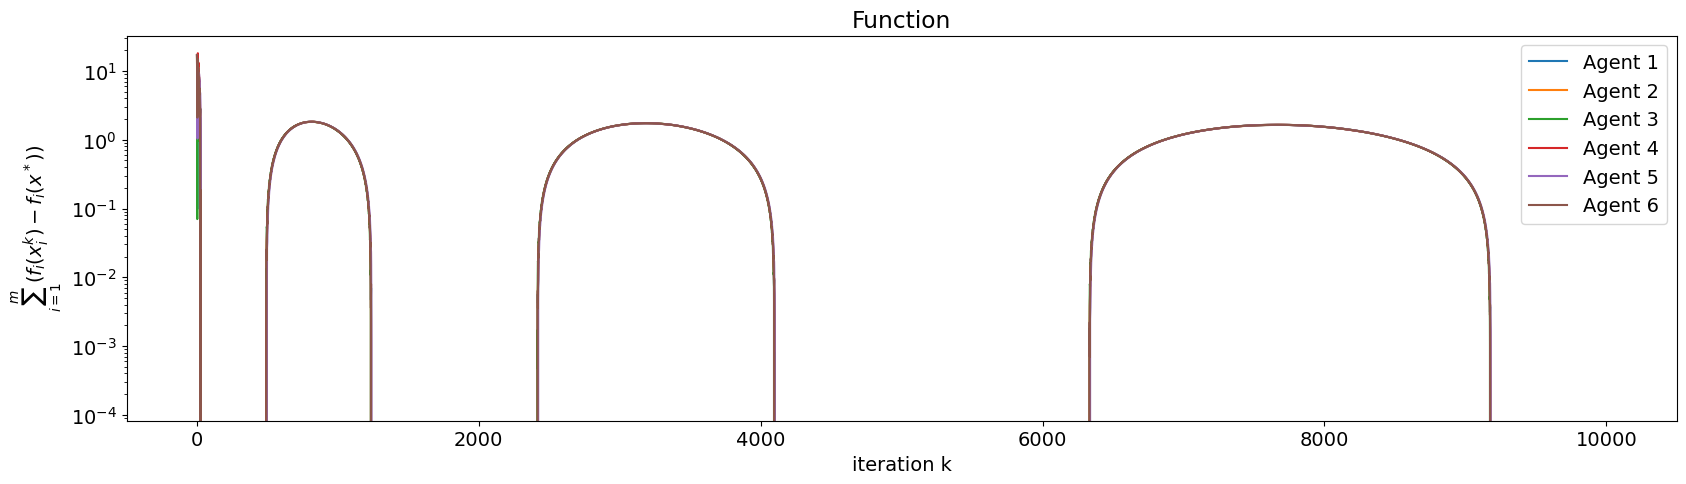

In [107]:
plt.figure(figsize=(20, 5))

for i in range(m):
    plt.plot(range(x_k.shape[0]-1), [F(x_k[k][i]) - F(x_opt) for k in range(x_k.shape[0]-1)], label=f"Agent {i+1}")
    
plt.yscale('log')
plt.legend()
plt.title("Function")
plt.xlabel("iteration k")
plt.ylabel("$ \sum_{i=1}^{m} (f_i(x_i^k) - f_i(x^*)) $")